In [1]:
import argparse
import os
import sys
import numpy as np

import torch
import matplotlib.pyplot as plt     # type: ignore

things_stim_path = '/user_data/mmhender/stimuli/things/'
save_stim_path = '/user_data/mmhender/stimuli/featsynth/images_v1'
texture_synth_root = os.path.dirname(os.getcwd())

texture_synth_root

sys.path.append(os.path.join(texture_synth_root, 'code'))

import utilities
import model_combineimages
import optimize_combineimages

import pandas as pd
import PIL
import time
import things_utils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/home/mmhender/imstat_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [20]:
class a:
    def __init__(self, n_ims_do=10):
        self.n_ims_do = n_ims_do

args = a(3)
args

concepts_filename = os.path.join(things_stim_path, 'concepts_use.npy')
concepts_use = np.load(concepts_filename,allow_pickle=True).item()
categ_names = concepts_use['categ_names']
concept_names_subsample = concepts_use['concept_names_subsample']
image_names = concepts_use['image_names']
concept_ids_subsample = concepts_use['concept_ids_subsample']
n_categ = len(categ_names)
n_conc_each = len(concept_names_subsample[0])

categ_process = np.arange(n_categ)
conc_process = np.arange(n_conc_each)
ims_process = np.arange(args.n_ims_do)

In [33]:
len(concept_names_subsample)

21

In [31]:
conc_process

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [20]:
n_ims_combine = len(ims_process)

# ca = 0;
ca = 4;
categ_ind = categ_process[ca]
categ = categ_names[categ_ind]
# co = 0; 
co = 9;
conc_ind = conc_process[co]
conc = concept_names_subsample[categ_ind][conc_ind]

target_image_filenames = [things_utils.get_filename(categ, conc, ii) for ii in ims_process]

print(target_image_filenames)

model_path = os.path.join(texture_synth_root, 'models','VGG19_normalized_avg_pool_pytorch')

args.lr = 1.0
args.max_iter = 20
args.checkpoint_every = 1
args.debug=True

args.n_steps = 10
# if args.debug:
#     args.n_steps = 1
args.rndseed = None

args.which_grid = 5
args.n_grid_eachside=1
args.do_sqrt = True

['/user_data/mmhender/stimuli/things/Images/wine/wine_01b.jpg', '/user_data/mmhender/stimuli/things/Images/wine/wine_02s.jpg', '/user_data/mmhender/stimuli/things/Images/wine/wine_03s.jpg']


In [21]:
layer_names_uppercase = ['Conv1','MaxPool1','MaxPool2','MaxPool3','MaxPool4']
n_layers = len(layer_names_uppercase)
overlap_each_layer = []
for ll in range(n_layers):

    fn = os.path.join(texture_synth_root,'grid_overlap','vgg19_gridoverlap_grid%d_%dx%d_%s.npy'%(args.which_grid,
                                                                           args.n_grid_eachside, 
                                                                    args.n_grid_eachside, 
                                                                    layer_names_uppercase[ll]))
    print('loading overlap from %s'%fn)
    overlap = np.load(fn)
    overlap_each_layer.append(overlap)

loading overlap from /user_data/mmhender/featsynth/texture_synthesis/grid_overlap/vgg19_gridoverlap_grid5_1x1_Conv1.npy
loading overlap from /user_data/mmhender/featsynth/texture_synthesis/grid_overlap/vgg19_gridoverlap_grid5_1x1_MaxPool1.npy
loading overlap from /user_data/mmhender/featsynth/texture_synthesis/grid_overlap/vgg19_gridoverlap_grid5_1x1_MaxPool2.npy
loading overlap from /user_data/mmhender/featsynth/texture_synthesis/grid_overlap/vgg19_gridoverlap_grid5_1x1_MaxPool3.npy
loading overlap from /user_data/mmhender/featsynth/texture_synthesis/grid_overlap/vgg19_gridoverlap_grid5_1x1_MaxPool4.npy


In [22]:
target_images = [utilities.preprocess_image(utilities.load_image(tname)) \
                for tname in target_image_filenames]

target_images_postproc = [utilities.postprocess_image(t, utilities.load_image(tname)) \
                          for t, tname in zip(target_images, target_image_filenames)]

In [23]:
important_layers = ['relu1_1', 'pool1','pool2','pool3','pool4']

layers_do = [1,2,3,4]

ll = 3;

layers_match = important_layers[0:ll+1]
spatial_weights_use = overlap_each_layer[0:ll+1]
print('making texture for layers:')
print(layers_match)

making texture for layers:
['relu1_1', 'pool1', 'pool2', 'pool3']


In [24]:
net = model_combineimages.Model(model_path, device, target_images, \
          important_layers=layers_match, \
          spatial_weights_list = spatial_weights_use, 
          do_sqrt = args.do_sqrt, 
          add_noise = False)

In [25]:
optimizer = optimize_combineimages.Optimizer(net, args)
optimizer

In [26]:
result = optimizer.optimize()

step: 1, loss: 109954544.0 (1.38s)
step: 2, loss: 27556422.0 (0.50s)
step: 3, loss: 6581984.0 (0.55s)
step: 4, loss: 1757953.375 (0.63s)
step: 5, loss: 670902.625 (0.57s)
step: 6, loss: 339461.375 (0.55s)
step: 7, loss: 215156.90625 (0.55s)
step: 8, loss: 153707.859375 (0.55s)
step: 9, loss: 115724.8359375 (0.55s)
step: 10, loss: 94081.8359375 (0.55s)


In [27]:

target_img_list = [utilities.load_image(tname) for tname in target_image_filenames]

final_image = utilities.postprocess_image_multiple_targets(
                        result, target_img_list)

Text(0.5, 0.98, 'target images, wine')

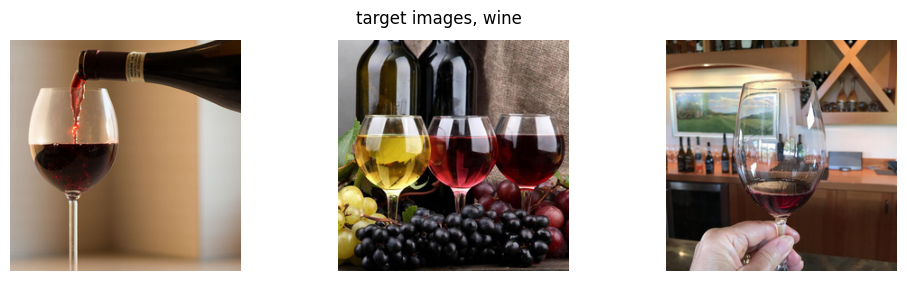

In [28]:
plt.figure(figsize=(12,3))

for ii in range(n_ims_combine):
    
    plt.subplot(1, n_ims_combine, ii+1)
    im = target_images_postproc[ii]
    plt.imshow(im)
    plt.axis('off')
    
plt.suptitle('target images, %s'%(conc))

Text(0.5, 1.0, 'result, wine')

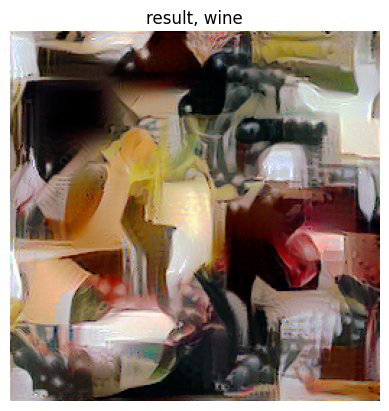

In [29]:
plt.figure()
plt.imshow(final_image)
plt.axis('off')
plt.title('result, %s'%(conc))

Text(0.5, 0.98, 'target images, toucan')

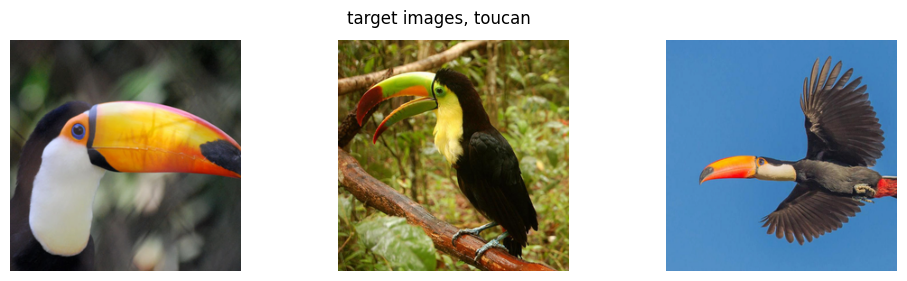

In [17]:
plt.figure(figsize=(12,3))

for ii in range(n_ims_combine):
    
    plt.subplot(1, n_ims_combine, ii+1)
    im = target_images_postproc[ii]
    plt.imshow(im)
    plt.axis('off')
    
plt.suptitle('target images, %s'%(conc))

Text(0.5, 1.0, 'result, toucan')

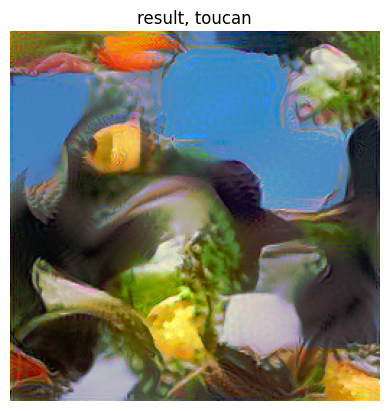

In [19]:
plt.figure()
plt.imshow(final_image)
plt.axis('off')
plt.title('result, %s'%(conc))